# Website Visits: Page Loads - Median of Medians

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Hyper-Parameters-Search" data-toc-modified-id="Hyper-Parameters-Search-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Hyper Parameters Search</a></span></li><li><span><a href="#Training-and-Validation" data-toc-modified-id="Training-and-Validation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training and Validation</a></span><ul class="toc-item"><li><span><a href="#Distributions-of-Validation-Errors" data-toc-modified-id="Distributions-of-Validation-Errors-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Distributions of Validation Errors</a></span></li><li><span><a href="#Visualization-of-Validation-Predictions" data-toc-modified-id="Visualization-of-Validation-Predictions-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Visualization of Validation Predictions</a></span></li></ul></li><li><span><a href="#Test-Predictions" data-toc-modified-id="Test-Predictions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test Predictions</a></span></li></ul></div>

## Initialization

In [2]:
# !pip install --use-feature=in-tree-build psutil requests pmdarima nb_black

In [3]:
# !pip install --use-feature=in-tree-build ../pytorch-fit/
# !pip install --use-feature=in-tree-build git+https://github.com/krzpiesiewicz/pytorch-fit

In [4]:
# !pip install --use-feature=in-tree-build ../timeseries/
# !pip install --use-feature=in-tree-build git+https://github.com/krzpiesiewicz/timeseries

In [5]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2
%aimport timeseries

<IPython.core.display.Javascript object>

In [6]:
import os
import IPython.display
from pprint import pprint
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

import timeseries as tss
from timeseries.plotting import plot_ts, plot_hist

from utils.timeseries_data import WebsiteVisitsData
from utils.results import Results
from utils.plotting import (
    plot_model_test_prediction,
    plot_ground_truth,
    plot_hist_model_scores,
)
from scorings import get_comparison_scorings
from average_scoring import average_scores
from hyper_params import make_grid, grid_search_hyper_params
from models.median_of_medians import MedianOfMediansModel

<IPython.core.display.Javascript object>

In [7]:
import nb_black

from utils.notebook_init import notebook_init

notebook_init()

<IPython.core.display.Javascript object>

In [8]:
scorings = get_comparison_scorings()

ts_data = WebsiteVisitsData()
data_type = ts_data.data_type
data_name = ts_data.data_name

val_results = Results(data_type, data_name, "val")
test_results = Results(data_type, data_name, "test")

ts = ts_data.ts
train_intv = ts_data.train_interval
val_intv = ts_data.val_interval
test_intv = ts_data.test_interval
pred_steps = ts_data.pred_steps
pred_jump = ts_data.pred_jump

<IPython.core.display.Javascript object>

## Hyper Parameters Search

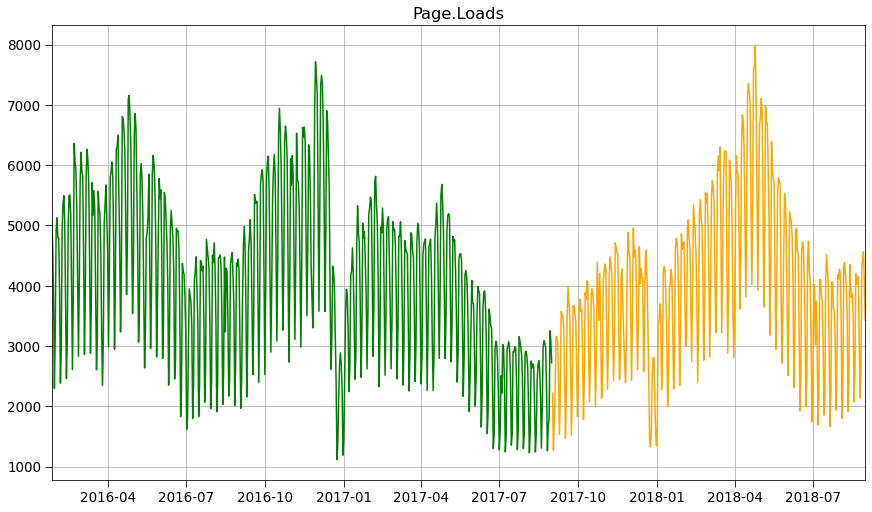

<IPython.core.display.Javascript object>

In [8]:
hyper_search_train_datetime = train_intv.begin
hyper_search_val_datetime = datetime(2017, 9, 1)
hyper_search_end_val_datetime = val_intv.begin
hyper_search_train_intv = tss.Interval(
    ts, hyper_search_train_datetime, hyper_search_val_datetime
)
hyper_search_val_intv = tss.Interval(
    ts, hyper_search_val_datetime, hyper_search_end_val_datetime
)
fig = plot_ts(hyper_search_train_intv.view(), color="green")
display(plot_ts(hyper_search_val_intv.view(), fig=fig, color="orange"))

In [9]:
def median_of_medians_grid_search(scores=None):
    return grid_search_hyper_params(
        MedianOfMediansModel,
        grid,
        ts,
        hyper_search_train_intv,
        hyper_search_val_intv,
        best=10,
        score_params=score_params,
        scores=scores,
    )

<IPython.core.display.Javascript object>

In [10]:
group_size_range = np.arange(1, 10).tolist() + [14, 21, 28]
n_groups_range = np.arange(1, 10).tolist()
m_range = [1, 7, 14, 28, 365]
grid = make_grid(n_groups=n_groups_range, group_size=group_size_range, m=m_range)
grid = [
    params
    for params in grid
    if params["group_size"] * params["n_groups"] * params["m"] <= 2 * 365
]

score_params = dict(
    scorings=["mae"],
    n_steps=pred_steps,
    n_steps_jump=20,
    mute=True,
)

<IPython.core.display.Javascript object>

In [11]:
%%time
pprint(median_of_medians_grid_search())

334/334, best_score: 335.087302, valuation: {'n_groups': 1, 'group_size': 1, 'm': 7}   
[(335.08730158730157, {'group_size': 1, 'm': 7, 'n_groups': 1}),
 (367.1111111111111, {'group_size': 2, 'm': 7, 'n_groups': 1}),
 (367.1111111111111, {'group_size': 1, 'm': 7, 'n_groups': 2}),
 (427.91269841269843, {'group_size': 3, 'm': 7, 'n_groups': 1}),
 (427.91269841269843, {'group_size': 1, 'm': 7, 'n_groups': 3}),
 (475.9603174603174, {'group_size': 1, 'm': 14, 'n_groups': 1}),
 (506.63888888888897, {'group_size': 4, 'm': 7, 'n_groups': 1}),
 (506.63888888888897, {'group_size': 2, 'm': 7, 'n_groups': 2}),
 (506.63888888888897, {'group_size': 1, 'm': 7, 'n_groups': 4}),
 (552.8095238095237, {'group_size': 5, 'm': 7, 'n_groups': 1})]
CPU times: user 1min 36s, sys: 288 ms, total: 1min 36s
Wall time: 1min 36s


<IPython.core.display.Javascript object>

## Training and Validation

In [11]:
%%time
model = MedianOfMediansModel(n_groups=1, group_size=1, m=7)
model.fit(ts, train_intv)
val_mean_scores, val_all_scores, val_preds = average_scores(
    model,
    ts,
    val_intv,
    scorings=scorings,
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(val_mean_scores)

model_name = "Median of Medians"
model_version = "(1,1)[7]"
val_results.set_model(model_name, model_version)
val_results.add_model_scores(val_mean_scores)
val_results.add_model_preds(val_preds)

61/61 – RMSE: 633.09232, MAE: 515.03981, MASE: 0.77538, sMAPE: 11.75158, elapsed time: 1.9s (last: 0.0s)      MASE: 0.96245, sMAPE: 14.28936, elapsed time: 1.3s (last: 0.0s)            
{'MAE': 515.03981264637,
 'MASE': 0.7753792411314667,
 'RMSE': 633.0923175674612,
 'sMAPE': 11.751578345832378}
CPU times: user 1.76 s, sys: 31.4 ms, total: 1.79 s
Wall time: 2.1 s


<IPython.core.display.Javascript object>

### Distributions of Validation Errors

In [13]:
scoring_name = "MAE"
display(
    plot_hist_model_scores(
        val_all_scores,
        scoring_name,
        data_name=data_name,
        model_name=model_name,
        model_version=model_version,
        engine="plotly",
    )
)

<IPython.core.display.Javascript object>

### Visualization of Validation Predictions

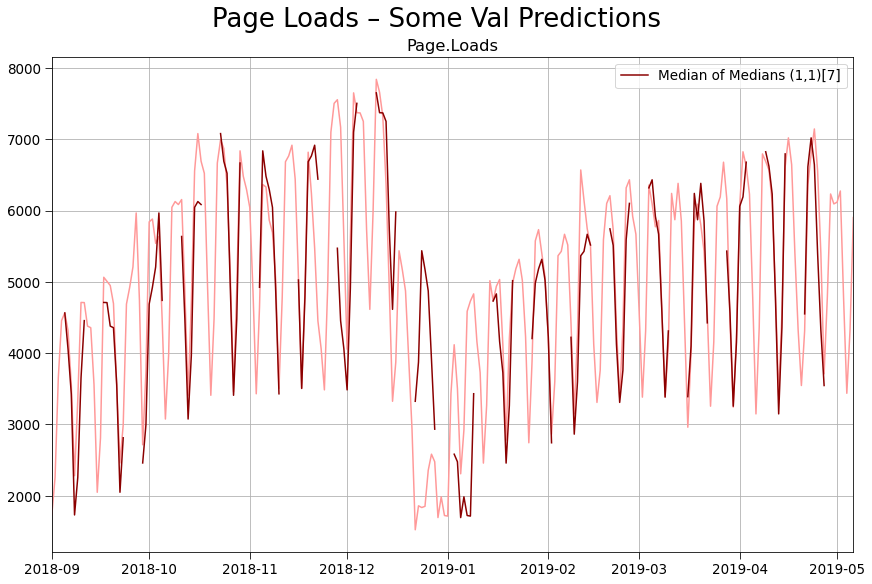

<IPython.core.display.Javascript object>

In [14]:
fig_time_delta = timedelta(days=3)
fig = plot_ground_truth(
    val_intv,
    mode="val",
    data_name=data_name,
)
display(
    plot_model_test_prediction(
        val_intv,
        fig_time_delta,
        val_preds,
        model_name=model_name,
        model_version=model_version,
        fig=fig,
    )
)

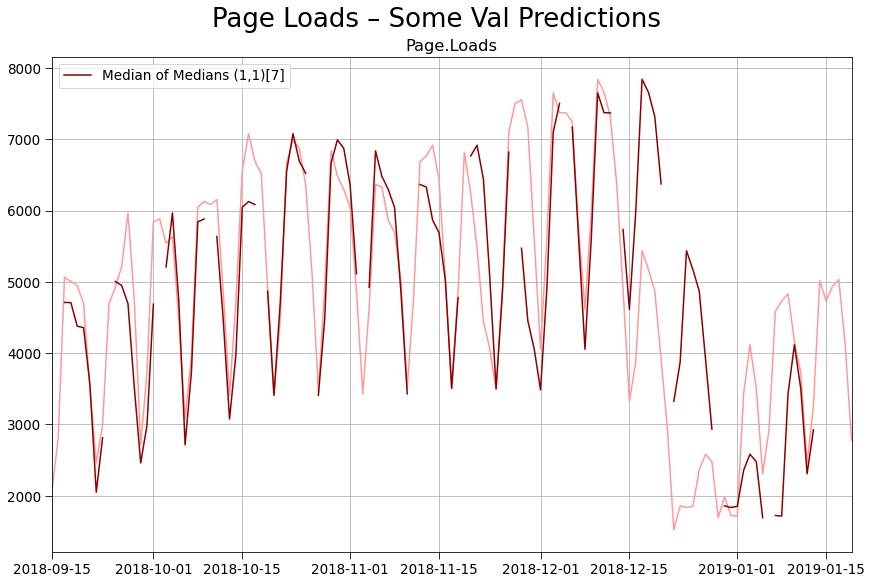

<IPython.core.display.Javascript object>

In [15]:
short_val_intv = tss.Interval(ts, datetime(2018, 9, 15), datetime(2019, 1, 20))
fig_time_delta = timedelta(days=1)
fig = plot_ground_truth(short_val_intv, mode="val", data_name=data_name)
display(
    plot_model_test_prediction(
        short_val_intv,
        fig_time_delta,
        val_preds,
        model_name=model_name,
        model_version=model_version,
        fig=fig,
    )
)

## Test Predictions

In [16]:
%%time
model.update(ts, val_intv)
test_mean_scores, test_all_scores, test_preds = average_scores(
    model,
    ts,
    test_intv,
    scorings=scorings,
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(test_mean_scores)
test_results.set_model(model_name, model_version)
test_results.add_model_scores(test_all_scores, test_mean_scores)
test_results.add_model_preds(test_preds)

116/116 – RMSE: 490.00376, MAE: 411.43596, MASE: 0.68100, sMAPE: 10.51355, elapsed time: 4.5s (last: 0.0s)      apsed time: 1.1s (last: 0.0s)      
{'MAE': 411.4359605911329,
 'MASE': 0.6810041540320858,
 'RMSE': 490.00375556570714,
 'sMAPE': 10.513546656171828}
CPU times: user 3.44 s, sys: 27.9 ms, total: 3.47 s
Wall time: 4.89 s


<IPython.core.display.Javascript object>